In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
import platform
print(platform.python_version())


3.10.12


In [ ]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install yfinance

In [ ]:
pip install statsmodels scipy

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import kerastuner as kt
from tensorflow.keras.layers import InputLayer

<ipython-input-7-759604ef955b>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define ticker symbols and date range
ticker_symbols = [
    'AMG', 'AMZN', 'AZO', 'BKNG', 'BLK', 'DUK', 'ED', 'F', 'FCX', 'GE',
    'GOOG', 'GPS', 'HBAN', 'ICE', 'LDOS', 'LMT', 'M', 'MTD', 'MYL', 'NKE',
    'ORLY', 'PBCT', 'PLD', 'RF', 'RJF', 'SHW', 'TDG', 'UAA', 'VFC', 'WEC'
]
start_date = '2010-01-01'
end_date = '2019-09-01'

# Fetch and prepare data
all_data = pd.DataFrame()
for symbol in ticker_symbols:
    data = yf.download(symbol, start=start_date, end=end_date)
    data['Ticker'] = symbol
    all_data = pd.concat([all_data, data])

all_data.index = pd.to_datetime(all_data.index)

# Count unique trading days
unique_trading_days = all_data.index.unique()
number_of_trading_days = len(unique_trading_days)
print(f"Number of unique trading days: {number_of_trading_days}")

feature_names = all_data.columns.tolist()
print("Feature names in the dataset:", feature_names)

all_data.ffill(inplace=True)
all_data.bfill(inplace=True)

all_data.to_csv("stock_data.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Number of unique trading days: 2432
Feature names in the dataset: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']


In [ ]:
# Relative Strength Index (RSI)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

all_data['RSI'] = RSI(all_data['Adj Close'])

# Moving Average Convergence Divergence (MACD)
def MACD(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line, macd - signal_line

all_data['MACD'], all_data['MACDSignal'], all_data['MACDHist'] = MACD(all_data['Adj Close'])

# Simple Moving Average (SMA)
all_data['SMA'] = all_data['Adj Close'].rolling(window=10).mean()

# Exponential Moving Average (EMA)
all_data['EMA'] = all_data['Adj Close'].ewm(span=10, adjust=False).mean()

# Average True Range (ATR)
def ATR(df, period=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(period).mean()
    return atr

all_data['ATR'] = ATR(all_data)

# Bollinger Bands
def bollinger_bands(series, period=20, std_dev=2):
    sma = series.rolling(window=period).mean()
    rstd = series.rolling(window=period).std()
    upper_band = sma + std_dev * rstd
    lower_band = sma - std_dev * rstd
    return upper_band, sma, lower_band

all_data['UpperBB'], all_data['MiddleBB'], all_data['LowerBB'] = bollinger_bands(all_data['Adj Close'])

# Calculate Log Returns
all_data['Log_Returns'] = np.log(all_data['Adj Close'] / all_data['Adj Close'].shift(1))

# Date-Based Indicators
all_data['day_of_week'] = all_data.index.dayofweek
all_data['month'] = all_data.index.month
all_data['quarter'] = all_data.index.quarter

# Moving averages over different windows to capture trends
all_data['rolling_mean_30'] = all_data['Adj Close'].rolling(window=30).mean()
all_data['rolling_mean_90'] = all_data['Adj Close'].rolling(window=90).mean()

# Rolling standard deviation to capture volatility changes
all_data['rolling_std_30'] = all_data['Adj Close'].rolling(window=30).std()

# Fourier series terms for seasonality
def fourier_series(length, periods):
    return np.column_stack([
        np.cos(2 * np.pi * np.arange(length) / p) for p in periods] +
        [np.sin(2 * np.pi * np.arange(length) / p) for p in periods])

periods = [365.25/2, 365.25, 365.25*2]
fourier_terms = fourier_series(len(all_data), periods)
fourier_df = pd.DataFrame(fourier_terms, index=all_data.index)
fourier_df.columns = [f'fourier_cos_{i+1}' for i in range(len(periods))] + [f'fourier_sin_{i+1}' for i in range(len(periods))]
all_data = pd.concat([all_data, fourier_df], axis=1)

all_data.dropna(inplace=True)

In [ ]:
# Feature engineering: Including lagged features for indicators
lags = 5
features_to_use = ['Log_Returns', 'RSI', 'MACD', 'SMA', 'EMA', 'ATR', 'UpperBB', 'MiddleBB', 'LowerBB',
                   'day_of_week', 'month', 'quarter', 'rolling_mean_30', 'rolling_mean_90',
                   'rolling_std_30'] + list(fourier_df.columns)

# Include lagged features for all
for feature in features_to_use:
    for lag in range(1, lags + 1):
        all_data[f'{feature}_lag_{lag}'] = all_data[feature].shift(lag)

all_data.dropna(inplace=True)

print(all_data.head)

<bound method NDFrame.head of                  Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2010-05-19  73.809998  75.410004  73.199997  75.010002  72.646385   601600.0   
2010-05-20  73.349998  73.839996  71.220001  71.290001  69.043610   536400.0   
2010-05-21  69.879997  73.099998  69.110001  72.889999  70.593178   516900.0   
2010-05-24  72.400002  72.680000  70.000000  70.040001  67.832985   414900.0   
2010-05-25  68.860001  69.500000  66.800003  69.400002  67.213150   745100.0   
...               ...        ...        ...        ...        ...        ...   
2019-08-26  92.930000  94.269997  92.610001  94.260002  81.987679  1928400.0   
2019-08-27  94.519997  96.459999  94.440002  95.309998  82.900955  2767300.0   
2019-08-28  95.529999  96.379997  94.720001  95.110001  82.726997  1951100.0   
2019-08-29  95.699997  95.970001  94.779999  95.930000  83.440239  1906400.0   
2019-08-30

In [ ]:
assert not all_data.isnull().values.any(), "NaN values are present in the dataset."

In [ ]:
def handle_outliers_with_count(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    outliers_after = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

    return df, outliers_before, outliers_after

features = ['RSI', 'MACD', 'SMA', 'EMA', 'ATR', 'UpperBB', 'MiddleBB', 'LowerBB', 'Log_Returns']
for feature in features:
    all_data, outliers_before, outliers_after = handle_outliers_with_count(all_data, feature)
    print(f"Feature '{feature}': Outliers before = {outliers_before}, Outliers after = {outliers_after}")

print("Data preprocessing is complete. The dataset is ready for scaling and LSTM modeling.")

Feature 'RSI': Outliers before = 196, Outliers after = 0
Feature 'MACD': Outliers before = 12845, Outliers after = 0
Feature 'SMA': Outliers before = 9410, Outliers after = 0
Feature 'EMA': Outliers before = 9428, Outliers after = 0
Feature 'ATR': Outliers before = 8962, Outliers after = 0
Feature 'UpperBB': Outliers before = 9353, Outliers after = 0
Feature 'MiddleBB': Outliers before = 9426, Outliers after = 0
Feature 'LowerBB': Outliers before = 9471, Outliers after = 0
Feature 'Log_Returns': Outliers before = 3861, Outliers after = 0
Data preprocessing is complete. The dataset is ready for scaling and LSTM modeling.


In [ ]:
# Define the features (X) and the target (y)
feature_columns = [col for col in all_data.columns if 'lag' in col]
X = all_data[feature_columns]
y = all_data['Log_Returns']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the sequence length
sequence_length = 10

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length][-1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Recreate sequences with the adjusted function
X_seq, y_seq = create_sequences(X_scaled, sequence_length)

# After adjusting, ensure the shapes align
print("Shape of X_seq:", X_seq.shape)
print("Shape of y_seq:", y_seq.shape)

# Split the data into training and test sets without shuffling
train_proportion = 0.9
split_idx = int(len(X_seq) * train_proportion)
X_train_seq, y_train_seq = X_seq[:split_idx], y_seq[:split_idx]
X_test_seq, y_test_seq = X_seq[split_idx:], y_seq[split_idx:]

Shape of X_seq: (67992, 10, 105)
Shape of y_seq: (67992,)


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Bidirectional(LSTM(32, activation='tanh', input_shape=(sequence_length, X_train_seq.shape[2]), return_sequences=True,
                       kernel_regularizer=l2(0.01))),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='tanh', kernel_regularizer=l2(0.01))),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f'Test Loss: {test_loss}')

Epoch 1/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - loss: 1.2272 - val_loss: 0.0177
Epoch 2/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.0234 - val_loss: 0.0078
Epoch 3/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.0144 - val_loss: 0.0055
Epoch 4/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0136 - val_loss: 0.0063
Epoch 5/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0141 - val_loss: 0.0105
Epoch 6/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0127 - val_loss: 0.0049
Epoch 7/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0120 - val_loss: 0.0059
Epoch 8/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0108 - val_loss: 0.0044
Epoch 9/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0107 - val_loss: 0.0049
Epoch 10/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0094 - val_loss: 0.0036
Epoch 11/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0115 - val_loss: 0.0036
Epoch 12/50
765/765 ━━━━━━━━━━

In [ ]:
predicted_in_sample = model.predict(X_train_seq).flatten()

residuals_in_sample = y_train_seq.flatten() - predicted_in_sample

predicted_out_of_sample = model.predict(X_test_seq).flatten()

residuals_out_of_sample = y_test_seq.flatten() - predicted_out_of_sample

1913/1913 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


LSTM MAE: 0.013819100952879963
LSTM RMSE: 0.017141682386993776


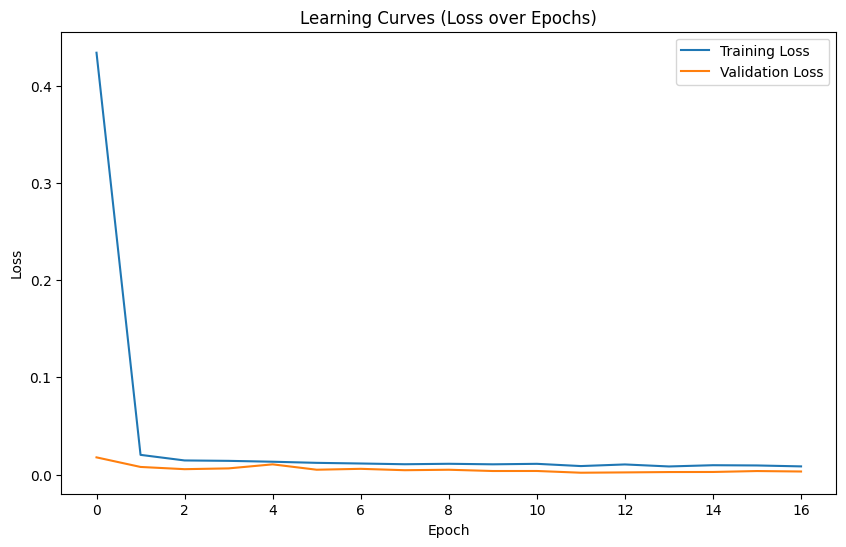

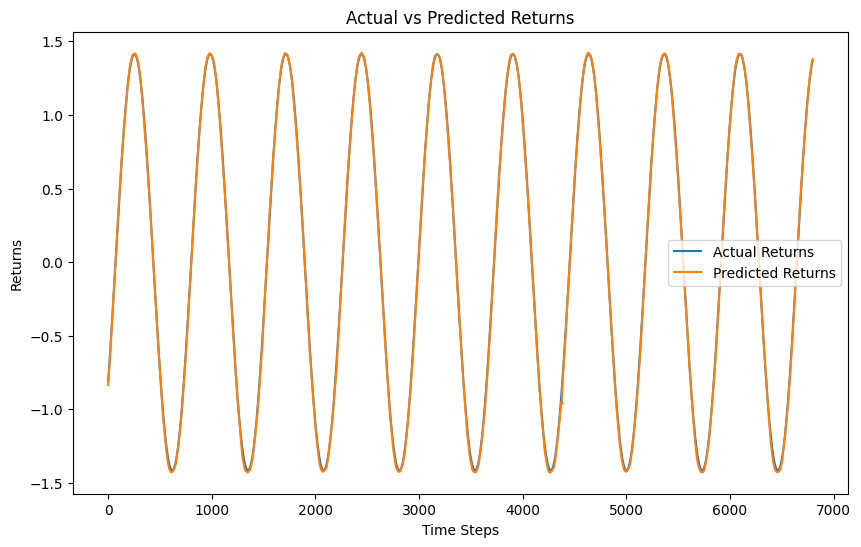

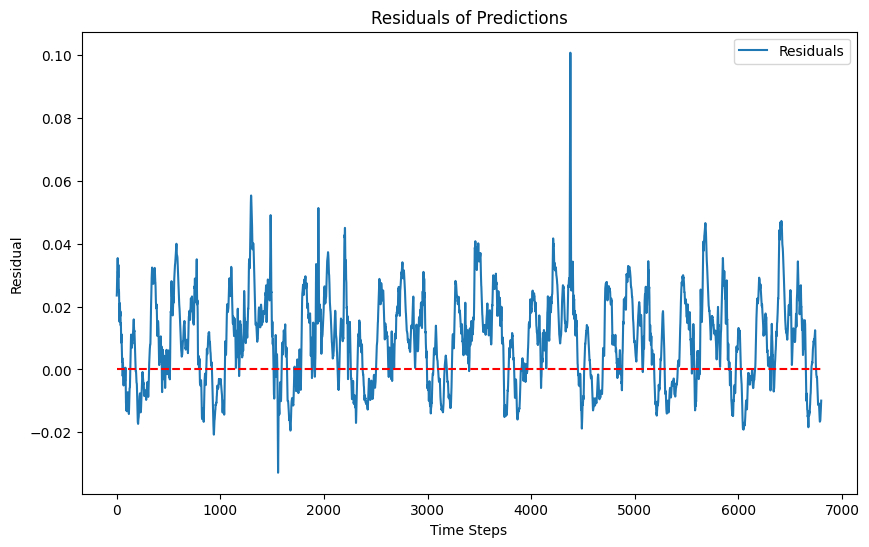

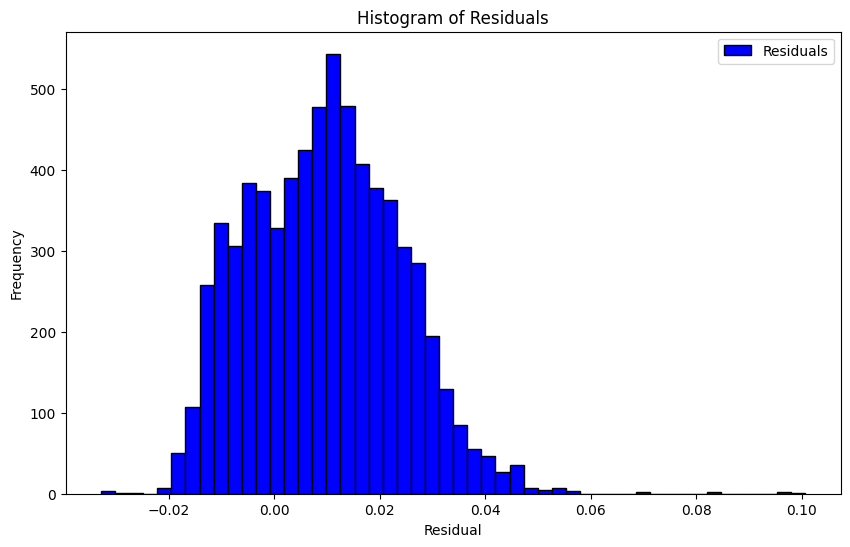

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

mae_lstm = mean_absolute_error(y_test_seq, predicted_out_of_sample)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, predicted_out_of_sample))

print(f'LSTM MAE: {mae_lstm}')
print(f'LSTM RMSE: {rmse_lstm}')

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves (Loss over Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual Returns')
plt.plot(predicted_out_of_sample, label='Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(residuals_out_of_sample, label='Residuals')
plt.hlines(y=0, xmin=0, xmax=len(residuals_out_of_sample), colors='r', linestyles='--')
plt.title('Residuals of Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Residual')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals_out_of_sample, bins=50, label='Residuals', color='blue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from arch import arch_model
from arch.univariate import FIGARCH

# Define additional functions for metrics
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def theils_u(actual, predicted, naive_forecast):
    actual_diff = actual[1:] - naive_forecast[:-1]
    predicted_diff = predicted[1:] - naive_forecast[:-1]
    return np.sqrt(np.mean(np.square(predicted_diff / actual_diff)))

# Define the model space for hyperparameter tuning
p_values = [0, 1]  # p parameter
q_values = [0, 1]  # q parameter
power_values = [1.0, 2.0]  # Power parameter, for FIAVGARCH or FIGARCH

# Placeholder for storing results
results = []

for p in p_values:
    for q in q_values:
        for power in power_values:
            try:
                model = arch_model(residuals_in_sample, vol='Figarch', p=p, q=q, power=power)
                res = model.fit(disp='off')

                 # Store the results
                results.append({
                    'p': p,
                    'q': q,
                    'power': power,
                    'AIC': res.aic
                })
            except Exception as e:
                print(f"An error occurred: {e}. Params: p={p}, q={q}, power={power}")

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results)

# Find the best model based on AIC
best_model_info = results_df.loc[results_df['AIC'].idxmin()]
print("Best FIGARCH model configuration based on AIC:")
print(best_model_info)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best FIGARCH model configuration based on AIC:
p             0.000000
q             0.000000
power         1.000000
AIC     -391127.585787
Name: 0, dtype: float64


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
# Best model configuration (Update these based on your best model found)
best_p = int(best_model_info['p'])
best_q = int(best_model_info['q'])
best_power = best_model_info['power']

# Fitting FIGARCH model (this syntax is hypothetical and depends on library support)
model = arch_model(residuals_in_sample, mean='Zero', vol='Figarch', p=best_p, q=best_q, power=best_power)
fitted_model = model.fit(disp='off')

# Forecasting with the fitted model
predicted_variances = []
for i in range(len(residuals_out_of_sample)):
    forecasts = fitted_model.forecast(horizon=1, start=i, method='simulation')
    predicted_variance = forecasts.variance.values[-1, :]
    predicted_variances.append(predicted_variance)

predicted_variances = np.array(predicted_variances[:len(residuals_out_of_sample)])

# Calculate MAE and RMSE
actual_variances = np.square(residuals_out_of_sample)
mae = mean_absolute_error(actual_variances, predicted_variances)
rmse = np.sqrt(mean_squared_error(actual_variances, predicted_variances))

print(f'MAE: {mae}, RMSE: {rmse}')

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(actual_variances, label='Actual Variance')
plt.plot(predicted_variances, label='Predicted Variance', alpha=0.7)
plt.title('Actual vs Predicted Variance')
plt.legend()
plt.show()

In [ ]:
# Sharpe Ratio Function
def sharpe_ratio(return_series, risk_free_rate=0.0):
    # Convert annual risk-free rate to per period
    rf_per_period = (1 + risk_free_rate)**(1/252) - 1
    excess_ret = return_series - rf_per_period
    return np.mean(excess_ret) / np.std(excess_ret)

# Calculate Sharpe Ratio for LSTM predicted returns
sharpe_ratio_lstm = sharpe_ratio(predicted_out_of_sample)

# Histogram of Out-of-Sample Residuals
plt.hist(residuals_out_of_sample, bins=50)
plt.title('Histogram of Out-of-Sample Residuals')
plt.show()

import scipy.stats as stats

# Q-Q Plot Function
def qq_plot(residuals):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Out-of-Sample Residuals')
    plt.show()

# Create Q-Q Plot
qq_plot(residuals_out_of_sample)
